# Main imports and code

In [311]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import torch.nn as nn

import logging
import torch
import random

from transformers import AutoTokenizer, RobertaModel, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader


In [312]:
# Check for GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS")
elif torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    for i in range(num_devices):
        device = torch.cuda.device(i)
        total_mem = torch.cuda.get_device_properties(i).total_memory / 1024**3  # Convert to GB
        allocated_mem = torch.cuda.memory_allocated(i) / 1024**3  # Convert to GB
        free_mem = total_mem - allocated_mem
        
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {total_mem:.1f}GB")
        print(f"Allocated Memory: {allocated_mem:.1f}GB")
        print(f"Free Memory: {free_mem:.1f}GB")
        
        if free_mem < 8:
            print(f"Warning: GPU {i} has less than 8GB of free VRAM!")
        else:
            print(f"Using GPU {i} with {free_mem:.1f}GB free VRAM")
            break 
    device = torch.device(f"cuda:{i}")
else:
    print("Warning: No GPU devices available - running on CPU only")
    device = torch.device("cpu")


Using MPS


In [313]:
# Prepare logger
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Loading and preprocessing data

In [314]:
# Helper function to save predictions to an output file
def labels2file(p, file_name):
	with open(f'./logs/{file_name}','w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

def convert_label_to_binary(x):
    return 0 if x in [0, 1] else 1

# Tokenize the dataset
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

# Data loader class
class PCLDataset(Dataset):
    def __init__(self, text_encodings, labels):
        self.text_encodings = text_encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.text_encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['country_code'] = f'dumm{idx}'
        return item

INFO:httpx:HTTP Request: HEAD https://huggingface.co/FacebookAI/roberta-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/FacebookAI/roberta-base/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/FacebookAI/roberta-base/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/FacebookAI/roberta-base/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/FacebookAI/roberta-base/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/FacebookAI/roberta-base/tree/main?recursive=true&expand=false "HTTP/1.1 200 OK"


In [315]:
# Loading dataframe
dataset_path = "Dont_Patronize_Me_Trainingset"
split_dataset_path = f'{dataset_path}/data_splits'

df = pd.read_csv(
    f'{dataset_path}/dontpatronizeme_pcl.tsv', 
    names=["par_id", "art_id", "keyword", "country_code", "text", "label"],
    sep='\t', 
    skiprows=4
)

train_csv = pd.read_csv(f'{split_dataset_path}/train_semeval_parids-labels.csv')
dev_csv = pd.read_csv(f'{split_dataset_path}/dev_semeval_parids-labels.csv')
test_csv = pd.read_csv(f'{split_dataset_path}/task4_test.tsv', 
    names=["t_id", "art_id", "keyword", "country_code", "text"],
    sep='\t', 
    skiprows=4
)

df.dropna(inplace=True)

# Clean HTML tokens
texts = df["text"].to_numpy()
rules = [("&amp;", "&"), ("More&gt;&gt;", ""), ("&gt;", ""), ("<h>", ""), (". .", "."), ("  ", " "), ("  ", " ")]
counter = 0
for (substring, replacement) in rules:
    df.loc[:, "text"] = df.loc[:, "text"].str.replace(substring, replacement) 

# Remove records with abnormally long sentence length
max_tokens_threshold = 200
texts = df["text"].to_numpy()
good_indices = list(map(lambda a: len(a.split()) < max_tokens_threshold, texts))
df = df[good_indices]
print(f'{len(texts) - sum(good_indices)} samples removed which had text length greater than threshold of {max_tokens_threshold}')

11 samples removed which had text length greater than threshold of 200


In [316]:
def dataset_rebuild(data_csv):
    rows = [] # will contain par_id, country_code, text and label
    for idx in range(len(data_csv)):  
        parid = data_csv["par_id"][idx]

        # If dataframe is empty, then sample was likely cleaned out of df
        if df.loc[df["par_id"] == parid].empty: continue

        # select row from original dataset to retrieve data
        keyword = df.loc[df["par_id"] == parid].keyword.values[0]
        country = df.loc[df["par_id"] == parid].country_code.values[0]
        text = df.loc[df["par_id"]  == parid].text.values[0]
        label = df.loc[df["par_id"]  == parid].label.values[0]
        rows.append({
            'par_id':parid,
            'country_code': country,
            'community':keyword,
            'text':text,
            'label':label
        })

    return pd.DataFrame(rows)

train_set = dataset_rebuild(train_csv)
train_set = train_set.sample(frac=1)
dev_set = dataset_rebuild(dev_csv)
test_set = test_csv

# Create datasets
train_text_encodings = tokenizer(list(train_set["text"].values), truncation=True, padding=True, max_length=256)
dev_text_encodings = tokenizer(list(dev_set["text"].values), truncation=True, padding=True, max_length=256)
test_text_encodings = tokenizer(list(test_set["text"].values), truncation=True, padding=True, max_length=256)

train_dataset = PCLDataset(train_text_encodings, train_set["label"].to_numpy())
dev_dataset = PCLDataset(dev_text_encodings, dev_set["label"].to_numpy())
test_dataset = PCLDataset(test_text_encodings, test_set["country_code"].to_numpy())

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Training baseline model

In [ ]:
# Downsample negative instances
pcldf = train_set[train_set.label==1]
npos = len(pcldf)
baseline_train_set = pd.concat([pcldf,train_set[train_set.label==0][:npos*2]])

train_text_encodings = tokenizer(list(baseline_train_set["text"].values), truncation=True, padding=True)
print(train_text_encodings)
dev_text_encodings = tokenizer(list(dev_set["text"].values), truncation=True, padding=True)

# Create downsampled training datasets
baseline_train_dataset = PCLDataset(train_text_encodings, baseline_train_set["label"].to_numpy())

# Create dataloaders
baseline_train_loader = DataLoader(baseline_train_dataset, batch_size=batch_size, shuffle=True)

torch.manual_seed(0)

model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=2).to(device)
optimiser = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()
softmax = torch.nn.Softmax(dim=0)
epoch = 10
num_warmup_steps = epoch * len(baseline_train_loader) * 0.1 
scheduler = get_linear_schedule_with_warmup(
    optimiser, num_warmup_steps=num_warmup_steps, num_training_steps= (epoch * len(baseline_train_loader))
)

model.train()
for e in range(epoch):
    for i, batch in enumerate(baseline_train_loader):
        torch.mps.empty_cache() # Not necessary if not using MPS
        optimiser.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids, attention_mask=attention_mask).logits
        loss = criterion(softmax(logits), labels)

        if ((i + 1) % 6 == 0):
            print(f'epoch: {e}, batch: {i + 1}, loss: {loss:.5f}, lr: {optimiser.param_groups[0]['lr']:.7f}')

        loss.backward()
        optimiser.step()
        scheduler.step()

# Save checkpoint
state = {
    'model_state_dict': model.state_dict()
}
torch.save(state, f'./baseline_models/model.pth')

{'input_ids': [[0, 21518, 505, 3893, 115, 157, 28, 2156, 624, 5, 7208, 9, 49, 781, 173, 4026, 11, 22312, 2156, 5, 25699, 9, 10, 1579, 7, 270, 4282, 1284, 7, 5486, 24287, 13, 39, 37854, 1413, 11, 20203, 6100, 12, 805, 1031, 3446, 13, 22534, 5, 12808, 9, 11661, 2114, 2219, 292, 153, 13573, 4175, 480, 566, 106, 1583, 9, 1653, 636, 1075, 12, 5400, 2286, 9, 5, 470, 211, 5003, 20523, 479, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 894, 56, 171, 3168, 2156, 65, 9, 61, 21, 930, 479, 91, 702, 5, 13305, 479, 91, 875, 484, 3686, 14, 25649, 5, 36171, 13, 184, 9, 5, 2841, 20593, 2156, 566

INFO:httpx:HTTP Request: HEAD https://huggingface.co/FacebookAI/roberta-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/FacebookAI/roberta-base/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/FacebookAI/roberta-base/resolve/main/model.safetensors "HTTP/1.1 302 Found"
Loading weights: 100%|██████████| 197/197 [00:00<00:00, 2325.17it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              
RobertaForSequenceClassification LOAD REPORT from: FacebookAI/roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm

torch.Size([16, 224])


INFO:httpx:HTTP Request: HEAD https://huggingface.co/FacebookAI/roberta-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/FacebookAI/roberta-base/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/FacebookAI/roberta-base/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/FacebookAI/roberta-base/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/FacebookAI/roberta-base/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/FacebookAI/roberta-base/tree/main?recursive=true&expand=false "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://hugg

completed iteration 0
completed iteration 100
completed iteration 200
completed iteration 300
completed iteration 400
completed iteration 500
completed iteration 600
completed iteration 700
completed iteration 800
completed iteration 900
completed iteration 1000
completed iteration 1100
completed iteration 1200
completed iteration 1300
completed iteration 1400
completed iteration 1500
completed iteration 1600
completed iteration 1700
completed iteration 1800
completed iteration 1900
completed iteration 2000
Evaluation finished!

[[1407  486]
 [ 133   66]]
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1893
           1       0.12      0.33      0.18       199

    accuracy                           0.70      2092
   macro avg       0.52      0.54      0.50      2092
weighted avg       0.84      0.70      0.76      2092



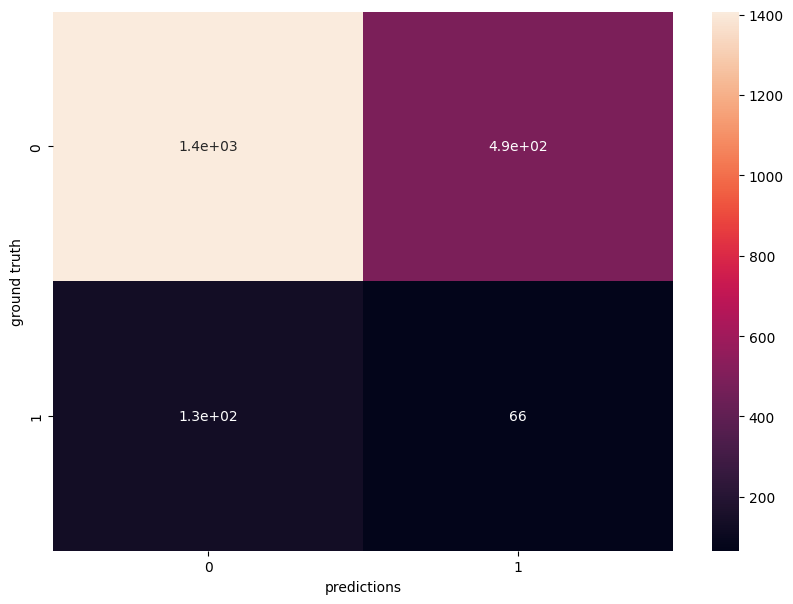

In [295]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base").to(device)
saved_state = torch.load("./baseline_models/model.pth")
model.load_state_dict(saved_state['model_state_dict'])

predictions, labels = [], []

model.eval()
with torch.no_grad():
    for index, row in dev_set.iterrows():
        labels.append(convert_label_to_binary(row.label))
        inputs = tokenizer(row.text, return_tensors="pt").to(device)
        logits = model(**inputs).logits
        predictions.append(logits.argmax(dim=1)[0].cpu())

        if (index % 100 == 0):
            print(f'completed iteration {index}')
print("Evaluation finished!\n")

# Reformat data
predictions = np.array(predictions)
labels = np.array(labels)
cm = confusion_matrix(labels, predictions)

# Print confustion matrix and metrics
print(cm)
print(classification_report(labels, predictions))

# Plot confustion matrix
df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True).set(xlabel = 'predictions', ylabel = 'ground truth')
plt.show()


# Implementing my approach

In [296]:
class MyModel(nn.Module):
    def __init__(self, latent_encoding_size = 256):
        super().__init__()

        self.encoder = RobertaModel.from_pretrained("FacebookAI/roberta-base")

        self.sequence_encoding_mlp = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(512, latent_encoding_size)
        )

        self.geo_embedding_mlp = nn.Sequential(
            nn.Linear(20, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, latent_encoding_size)
        )

        self.layer1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
        )
        self.output = nn.Sequential(
            nn.Linear(256, 5),
            nn.BatchNorm1d(5),
            nn.Softmax(),
        )

    def forward(self, input_ids, attention_mask, geo_tokens):
        # Get geographical 
        geo_embedding = self.geo_embedding_mlp(self.encode_geoloc(geo_tokens))

        # Encode text tokens
        encoding = self.encoder(input_ids, attention_mask).last_hidden_state[:, 0:]
        encoding = self.sequence_encoding_mlp(encoding)

        # MLP layer
        x = encoding + geo_embedding
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)

        return x

    def encode_geoloc(self, country_encodings):
        results, one_hot_encoding = [], ['au','bd','ca','gb','gh','hk','ie','in','jm','ke','lk','my','ng','nz','ph','pk','sg','tz','us','za']
        for c in country_encodings:
            results.append([1.0 if (one_hot_encoding.index(c) == i) else 0.0 for i in range(len(one_hot_encoding))])

        return results
        
        

In [317]:
tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

new_model = MyModel().to(device)
optimiser = torch.optim.AdamW(new_model.parameters(), lr=2e-4, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss()
epoch = 10
num_warmup_steps = epoch * len(train_loader) * 0.1 
scheduler = get_linear_schedule_with_warmup(
    optimiser, num_warmup_steps=num_warmup_steps, num_training_steps= (epoch * len(train_loader))
)

torch.manual_seed(0)

new_model.train()
for e in range(epoch):
    for i, batch in enumerate(train_loader):
        torch.mps.empty_cache() # Not necessary if not using MPS
        optimiser.zero_grad()

        print([k for k in batch])
        input_ids = batch['input_ids'].to(device)
        print(input_ids.shape)
        attention_mask = batch['attention_mask'].to(device)
        print(attention_mask.shape)
        print(batch['labels'].shape)
        print(batch['country_code'])
        outputs = new_model(input_ids, attention_mask)
        input_embeddings = outputs.hidden_states[0]
        
        labels = batch['labels'].to(device)
        loss = criterion(softmax(logits), labels)

        if ((i + 1) % 6 == 0):
            print(f'epoch: {e}, batch: {i + 1}, loss: {loss:.5f}, lr: {optimiser.param_groups[0]['lr']:.7f}')

        loss.backward()
        optimiser.step()
        scheduler.step()

        break

# # Save checkpoint
# state = {
#     'model_state_dict': new_model.state_dict()
# }
# torch.save(state, f'./new_models/model.pth')

INFO:httpx:HTTP Request: HEAD https://huggingface.co/FacebookAI/roberta-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/FacebookAI/roberta-base/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/FacebookAI/roberta-base/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/FacebookAI/roberta-base/e2da8e2f811d1448a5b465c236feacd80ffbac7b/tokenizer_config.json "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/FacebookAI/roberta-base/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/FacebookAI/roberta-base/tree/main?recursive=true&expand=false "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://hugg

['input_ids', 'attention_mask', 'labels', 'country_code']
torch.Size([16, 225])
torch.Size([16, 225])
torch.Size([16])
['dumm6706', 'dumm7480', 'dumm893', 'dumm7423', 'dumm4684', 'dumm866', 'dumm2892', 'dumm7022', 'dumm2318', 'dumm6561', 'dumm2311', 'dumm129', 'dumm2192', 'dumm6824', 'dumm3765', 'dumm5438']


TypeError: MyModel.forward() missing 1 required positional argument: 'geo_tokens'